In [1]:
#Import modules
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt

import cmath

ci = complex(0, 1)

In [2]:
def RK4(xn, yn, dt, f, *args):
    k1 = dt*f(xn, yn, *args)
    k2 = dt*f(xn + dt/2, yn + k1/2, *args)
    k3 = dt*f(xn + dt/2, yn + k2/2, *args)
    k4 = dt*f(xn + dt, yn + k3, *args)
    
    #Return x_{n+1} and y_{n+1} as new x_n and y_n
    xn = xn + dt
    yn = yn + (k1 + 2*k2 + 2*k3 + k4)/6
    return xn, yn

In [3]:
#Electric Field
E0 = 0.0534
omega = 0.114
phi = 0

#Envelope with mean at t=0 and duration of 128 au
def envelope(t):
    return (np.cos(np.pi*t/128))**2

def E(t):
    return E0 * envelope(t) * np.cos(omega*t + phi)

In [4]:
#Newton's Equation
def ddx(t, dx, x):
    return -E(t) - np.absolute(x)/x**3

def dx(t, x, v):
    return v

In [5]:
#Ionization Potential
Ip = 0.5

#Keldysh Parameter
kel = omega*np.sqrt(2*Ip)/E0

#Final time
tf = 64

In [6]:
#Initial velocity
v0 = 0
v0t = 0

In [22]:
#Number of trials
N = 1*10**4

final_p = np.empty(N)
weights = np.empty(N)
phases = np.empty(N)

#Loop over number of trials
for j in range(N):

    #Choose time and find initial position
    #Step size of 0.005 au for time
    t = np.linspace(-64, 64, 25600)
    index = rand.randint(0, 25600)
    t0 = t[index]

    x = np.zeros(25600)
    x[index] = (-Ip - np.sqrt(Ip**2 - 4*np.absolute(E(t0))))/(2*E(t0))

    p = np.zeros(25600)
    p[index] = v0

    #Solving the IVP
    for i in range(index+1, 25600):
        dt = t[i] - t[i-1]
        throw, x[i] = RK4(t[i-1], x[i-1], dt, dx, p[i-1])
        throw, p[i] = RK4(t[i-1], p[i-1], dt, ddx, x[i-1])

    t = t[index:]
    x = x[index:]
    p = p[index:]
    
    #List of final momenta
    final_p[j] = p[-1]
    
    #List of weights
    weights[j] = np.exp(-2*(2*Ip)**1.5 / (3*E(t0))) * np.exp(-np.sqrt(2*Ip)*v0t**2 / (E(t0)))
    
    #List of phases
    #Parameters from Semiclassical 2-Step paper
    L = 0
    H = (p[-1])**2 / 2 - 1/np.absolute(x[-1])
    b = 1/(2*H)
    g = np.sqrt(1 + 2*H*(L**2))
    #Build answer
    answer = -v0t*x[0] + Ip*t0
    answer = answer - cmath.sqrt(b)*(np.log(g) + np.arcsinh(x[-1]*p[-1]/(g*cmath.sqrt(b))))
    integrand = p**2 / 2 - 2/np.absolute(x)
    integral = (64-t0)*np.average(integrand)
    phases[j] = answer - integral
    
print('done')

<ipython-input-22-349f6407bba1>:50: ComplexWarning: Casting complex values to real discards the imaginary part
  phases[j] = answer - integral
<ipython-input-22-349f6407bba1>:37: RuntimeWarning: overflow encountered in exp
  weights[j] = np.exp(-2*(2*Ip)**1.5 / (3*E(t0))) * np.exp(-np.sqrt(2*Ip)*v0t**2 / (E(t0)))


KeyboardInterrupt: 

In [19]:
#Will cut off momenta at -20 and 20 (otherwise run risk of being too big)
bin_size = 0.01
bins_pos = []
bins_neg = []
bins_w_pos = []
bins_S_pos = []
bins_w_neg = []
bins_S_neg = []

#Back up the lists in case code doesn't work
#final_p = final_p_bu
#weights = weights_bu
#phases = phases_bu

final_p_bu = final_p
weights_bu = weights
phases_bu = phases

#Allocate momenta into bins
for i in range(200):
    bins_pos.append([])
    bins_w_pos.append([])
    bins_S_pos.append([])
    for j in range(len(final_p)):
        if final_p[j] > bin_size*i and final_p[j] < bin_size*(i+1):
            bins_pos[i].append(final_p[j])
            #final_p[j] = 0
            bins_w_pos[i].append(weights[j])
            #weights[j] = 0
            bins_S_pos[i].append(phases[j])
            #phases[j] = 0
    #final_p = final_p[final_p!=0]
    #weights = weights[weights!=0]
    #phases = phases[phases!=0]

for i in range(200):
    bins_neg.append([])
    bins_w_neg.append([])
    bins_S_neg.append([])
    for j in range(len(final_p)):
        if final_p[j] < -bin_size*i and final_p[j] > -bin_size*(i+1):
            bins_neg[i].append(final_p[j])
            #final_p[j] = 0
            bins_w_neg[i].append(weights[j])
            #weights[j] = 0
            bins_S_neg[i].append(phases[j])
            #phases[j] = 0
    #final_p = final_p[final_p!=0]
    #weights = weights[weights!=0]
    #phases = phases[phases!=0]
         
#Concatenate lists
bins = []
for m in range(1, len(bins_neg)+1):
    bins.append(bins_neg[-m])
bins = bins + bins_pos
bins_w = []
for m in range(1, len(bins_w_neg)+1):
    bins_w.append(bins_w_neg[-m])
bins_w = bins_w + bins_w_pos
bins_S = []
for m in range(1, len(bins_S_neg)+1):
    bins_S.append(bins_S_neg[-m])
bins_S = bins_S + bins_S_pos

print('done')

done


In [37]:
#Probability in bins
def prob_bin(w_bin, S_bin):
    answer = 0
    for k in range(len(w_bin)):
        answer = answer + (np.sqrt(w_bin[k]) * np.exp(ci*S_bin[k]))
    return np.real(answer * np.conj(answer))
         
momenta = np.linspace(-1.95/2, 1.95/2, len(bins))

prob = np.empty(len(bins))
for i in range(len(bins)):
    prob[i] = prob_bin(bins_w[i], bins_S[i])

<ipython-input-37-b0c5315120c3>:5: RuntimeWarning: invalid value encountered in cdouble_scalars
  answer = answer + (np.sqrt(w_bin[k]) * np.exp(ci*S_bin[k]))


400


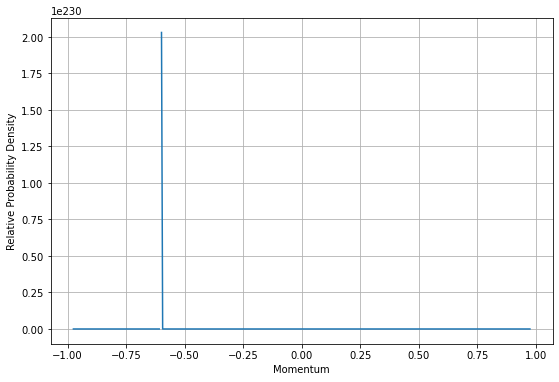

In [38]:
print(len(prob))

#Plot graph
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(momenta, prob)
ax.set(xlabel='Momentum', ylabel='Relative Probability Density')
plt.grid(True)
plt.show()